### Obective: To apply Logistic Regression on amazon fine food reviews

In [1]:
import warnings
warnings.filterwarnings("ignore")

#import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate


In [3]:
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression


In [4]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import TimeSeriesSplit,GridSearchCV
#from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report


In [5]:
# Loading data 
customer_reviews = pd.read_csv('../input/Reviews.csv')
customer_reviews.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
customer_reviews.shape 
# there are 568454 reviews food products from amazon

(568454, 10)

In [7]:
# keeping those reviews where score is either less than 3 or greater than 3

filtered_data = customer_reviews[customer_reviews.Score!=3]
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [8]:
#looking at the number of attributes and size of the data after filtering
filtered_data.shape

(525814, 10)

In [9]:
# converting Score >3 into postive and <3 into negative

def convert(x):
    if x>3:
        return "positive"
    return "negative"


filtered_data['Score'] = filtered_data['Score'].map(convert)
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Exploratory Data Analysis

## Data Cleaning

After analysis it was found that a review with same parameter other than ProductId may belong to same product.Hence we first sort the data according to ProductId and then just keep first similar product review and delete the others

In [10]:

sorted_data = filtered_data.sort_values(['ProductId'])
sorted_data.drop_duplicates({"UserId","ProfileName","Time","Text"} , keep = 'first' , inplace = True )
sorted_data.shape

(364173, 10)

### Observation:
HelpfulnessNumerator is greater than HelpfulnessDenominator is not practically possible hence removing such rows


In [11]:
# removing rows where HelpfulnessNumerator is greater than HelpfulnessDenominator
final_data = sorted_data[sorted_data.HelpfulnessNumerator <= sorted_data.HelpfulnessDenominator]
final_data.shape

(364171, 10)

In [12]:

# checking how much data is still remaining
(final_data['Id'].size/filtered_data['Id'].size)*100

69.25852107399194

Only 69.25% of data is remaining after removing duplicates and non pratical values

# Text Preprocessing

### Preprocessing phase involves following steps:
1. removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Stemming 

In [13]:
#nltk.download('stopwords')
stop = set(stopwords.words('english'))  # set of english stopwords
stop.remove("not")  
print(stop)

sno = nltk.stem.SnowballStemmer('english') # initializing snowball stemmer



{'over', 'own', 'wouldn', 'then', 'wasn', 'its', 'yourselves', 'yours', 'about', 'other', 'or', 'itself', 'my', 'nor', 'their', 'an', 'having', "shan't", 'be', "don't", 'under', 'most', "needn't", 'what', 'while', 'themselves', 'where', 'with', 'because', 'our', 'have', "didn't", 'by', 'don', 'below', 'more', 'here', 'there', "shouldn't", 'of', 'weren', "wasn't", 'very', 'when', 'each', "it's", 'too', 'at', "she's", 'himself', 'such', 'did', 'if', 'ours', 'on', "wouldn't", 'doing', 'before', 'she', 'yourself', 'your', 'are', 'how', 'didn', 'm', 'isn', 've', "hasn't", 'but', 'all', 'they', 'been', 'into', 'this', 'them', 'any', 'will', "you've", 'through', "mustn't", 're', 'is', "isn't", 'ma', 'it', 'few', "couldn't", 'd', 'hadn', 'after', 'to', 'was', "that'll", 's', "should've", 'ourselves', 'o', 'aren', 'do', 'mustn', "you're", "you'd", 'those', 'between', 'am', 'which', 'these', 'her', 'same', 'mightn', 'from', 'just', 'me', 'hasn', 'so', 'won', 'should', 'up', 'shouldn', 'haven', '

In [14]:
def cleanhtml(sentence):    # function for removing html
    cleanr = re.compile('<.*?>')
    cleantxt = re.sub(cleanr , ' ' , str(sentence))
    return cleantxt

def cleanpunc(sentence):    # function for removing punctuation
    clean = re.sub(r'[?|!|\'|"|#|.|,|)|(|\|/]', r' ' , sentence)
    return clean


In [15]:
final_data['com_text'] = final_data['Summary'] + ' ' + final_data['Text'] 
final_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,com_text
150523,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,EVERY book is educational this witty little bo...
150505,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...","Love the book, miss the hard cover version I g..."
150506,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,chicken soup with rice months This is a fun wa...
150507,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,a good swingy rhythm for reading aloud This is...
150508,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,A great way to learn the months This is a book...


In [16]:
i = 0
final_string = []
all_pos_words = []
all_neg_words = []
str1 = ' '
s = ' '
ss = final_data['com_text'].values
for sent in ss:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # removing HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):# checking if word is not alpha numeric and length is greater than 2
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final_data['Score'].values)[i] == 'positive': 
                        all_pos_words.append(s) 
                    if(final_data['Score'].values)[i] == 'negative':
                        all_neg_words.append(s) 
                else:
                    continue
            else:
                continue 
    
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    
    final_string.append(str1)
    i+=1
            
        

In [17]:
final_data['CleanedText'] = final_string  # adding extra column for preprocessed review
final_data['CleanedText'] = final_data['CleanedText'].str.decode("utf8")
#final_data.head()
final_data['Score'].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

### Observation:
Dataset is highly imbalanced. Out of 364171 reviews only 57110 reviews are negative and rest are positive. 
 

In [18]:
# sorting whole  data based on time
b = final_data
b['Time'] = pd.to_datetime(b['Time'], unit = "s")
b.sort_values('Time', inplace = True)

#sampled_data.sort_values('Time',axis=0,kind="quicksort", ascending=True , inplace = True)

In [19]:
b.head(20) 

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,com_text,CleanedText
150523,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,EVERY book is educational this witty little bo...,everi book educ witti littl book make son laug...
150500,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,This whole series is great way to spend time w...,whole seri great way spend time child rememb s...
451855,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,Entertainingl Funny! Beetlejuice is a well wri...,entertainingl funni beetlejuic well written mo...
374358,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",A modern day fairy tale A twist of rumplestisk...,modern day fairi tale twist rumplestiskin capt...
451854,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,2000-01-03,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,FANTASTIC! Beetlejuice is an excellent and fun...,fantast beetlejuic excel funni movi keaton hil...
374421,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,positive,2000-01-09,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,GREAT THIS IS ONE MOVIE THAT SHOULD BE IN YOUR...,great one movi movi collect fill comedi action...
374342,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,negative,2000-01-19,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",WARNING: CLAMSHELL EDITION IS EDITED TV VERSIO...,clamshel edit edit version alway enjoy movi fu...
76881,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,positive,2000-01-24,A sure death for flies,I bought a few of these after my apartment was...,A sure death for flies I bought a few of these...,sure death fli bought apart infest fruit fli h...
374449,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,positive,2000-02-26,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...,Bettlejuice...Bettlejuice...BETTLEJUICE! What ...,bettlejuic bettlejuic bettlejuic happen say na...
374399,374400,B00004CI84,A2DEE7F9XKP3ZR,jerome,0,3,positive,2000-06-03,Research - Beatlejuice video - French version,I'm getting crazy.I'm looking for Beatlejuice ...,Research - Beatlejuice video - French version ...,research beatlejuic video french version get c...


After reading first few reviews it is found that the data still has few reviews that does not belong to food products. These reviews are of products like books or movies.

In [20]:
# removing reviews that belong to other products
regex =  re.compile(r'book|entertaining|funny|movie|show|film|series|educational|storyteller|comedic') 
text =    b.Text.str.lower().str.contains(regex)
b.drop(b[text].index , inplace=True )

In [21]:
# Number of reviews left
b.shape

(353205, 12)

In [22]:
# creating a new column to get the length of each text
b['text length'] = b['CleanedText'].apply(len)
b.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,com_text,CleanedText,text length
76881,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,positive,2000-01-24,A sure death for flies,I bought a few of these after my apartment was...,A sure death for flies I bought a few of these...,sure death fli bought apart infest fruit fli h...,172
374449,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,positive,2000-02-26,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...,Bettlejuice...Bettlejuice...BETTLEJUICE! What ...,bettlejuic bettlejuic bettlejuic happen say na...,633
1244,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,positive,2000-06-23,Great Product,This was a really good idea and the final prod...,Great Product This was a really good idea and ...,great product realli good idea final product o...,116
1243,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,positive,2000-06-29,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,WOW Make your own 'slickers' ! I just received...,wow make slicker receiv shipment could hard wa...,250
131216,131217,B00004RAMX,A5NQLNC6QPGSI,Kim Nason,7,8,positive,2000-07-31,End your Gopher Problems,I have just recently purchased the Woodstream ...,End your Gopher Problems I have just recently ...,end gopher problem recent purchas woodstream c...,275


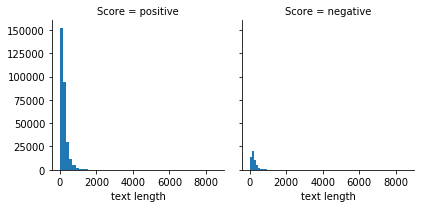

In [23]:
import seaborn as sns
g = sns.FacetGrid(data = b , col = 'Score')
g.map(plt.hist , 'text length' , bins = 50)
plt.show()

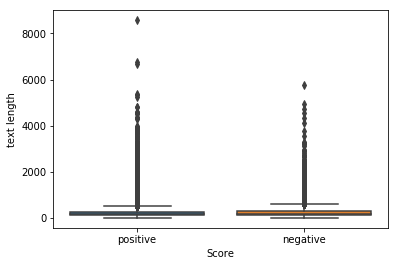

In [24]:
sns.boxplot(x='Score', y='text length', data=b)
plt.show()

### Function for standardizing data

In [25]:
from sklearn.preprocessing import StandardScaler

In [26]:

def std_data(matrix):
    scaler  = StandardScaler(with_mean=False)
    scaler.fit(matrix)
    return scaler.transform(matrix) 
 

In [41]:
# picking top 100k data points 
sampled_data = b.head(100000)

In [42]:
sampled_data.sort_values(by = 'Time' , inplace = True)

In [43]:
sampled_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,com_text,CleanedText,text length
76881,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,positive,2000-01-24,A sure death for flies,I bought a few of these after my apartment was...,A sure death for flies I bought a few of these...,sure death fli bought apart infest fruit fli h...,172
374449,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,positive,2000-02-26,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...,Bettlejuice...Bettlejuice...BETTLEJUICE! What ...,bettlejuic bettlejuic bettlejuic happen say na...,633
1244,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,positive,2000-06-23,Great Product,This was a really good idea and the final prod...,Great Product This was a really good idea and ...,great product realli good idea final product o...,116
1243,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,positive,2000-06-29,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,WOW Make your own 'slickers' ! I just received...,wow make slicker receiv shipment could hard wa...,250
131216,131217,B00004RAMX,A5NQLNC6QPGSI,Kim Nason,7,8,positive,2000-07-31,End your Gopher Problems,I have just recently purchased the Woodstream ...,End your Gopher Problems I have just recently ...,end gopher problem recent purchas woodstream c...,275


In [44]:
# splitting  data into train and test set
def response_label(sign):
    if sign == "positive":
        return 1                               # positive-----> 1
    else:
        return -1                              # negative-----> -1 
    
sampled_data["Score"] = sampled_data["Score"].map(response_label)
X_train, X_test, Y_train, Y_test , len_train , len_test  = train_test_split(sampled_data['CleanedText'],sampled_data['Score'],sampled_data['text length'], test_size=0.3, random_state=45)

In [45]:
Y_train.value_counts()

 1    61494
-1     8506
Name: Score, dtype: int64

## Bag of Words

#### Vectorizing & Standarzing both train and test data

In [35]:
#CountVectorizer()--> Converts a collection of text documents to a matrix of token counts

# Initialize a CountVectorizer object: count_vectorizer
count_vect = CountVectorizer(ngram_range = (1,2) , dtype = 'float')

# Transforming train/test data into bag of words
bow_X_train_matrix = count_vect.fit_transform(X_train.values)
print("Train Dataset: ", bow_X_train_matrix.shape)

bow_X_test_matrix = count_vect.transform(X_test.values)
print("Test Dataset: " , bow_X_test_matrix.shape)

Train Dataset:  (70000, 923115)
Test Dataset:  (30000, 923115)


In [38]:
from scipy.sparse import hstack
bow_X_train_matrix = hstack((bow_X_train_matrix,np.array(len_train)[:,None]))
bow_X_test_matrix = hstack((bow_X_test_matrix,np.array(len_test)[:,None]))

In [39]:
# standarzing both train and test matrix 
bow_std_X_train_matrix = std_data(bow_X_train_matrix)
bow_std_X_test_matrix = std_data(bow_X_test_matrix)

###  Grid Search Cross Validation 


In [46]:
from sklearn.model_selection import RandomizedSearchCV

tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
# grid search
LR_model = LogisticRegression(penalty = 'l2')
tscv = TimeSeriesSplit(n_splits=10)                    
BOW_l2_clf_using_grid = GridSearchCV(LR_model, tuned_parameters, cv = tscv,scoring='f1' , n_jobs = -1)
BOW_l2_clf_using_grid.fit(bow_std_X_train_matrix , Y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'C': [0.0001, 0.01, 1, 100, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [47]:
cv_score = list(BOW_l2_clf_using_grid.cv_results_.get('mean_test_score'))
C_values = [10**-4, 10**-2, 10**0, 10**2, 10**4]
for i in range(len(cv_score)):
    print('f1_score for each C = ',C_values[i],'is ',cv_score[i] )

f1_score for each C =  0.0001 is  0.9389320263311436
f1_score for each C =  0.01 is  0.9402431112583883
f1_score for each C =  1 is  0.9415790948432426
f1_score for each C =  100 is  0.94205938278329
f1_score for each C =  10000 is  0.9420511548190318


In [48]:
# applying grid search on l1 regulizer
LR_model_l1 = LogisticRegression(penalty = 'l1')
tscv = TimeSeriesSplit(n_splits=10)
BOW_l1_clf_using_grid = GridSearchCV(LR_model_l1, tuned_parameters, cv = tscv,scoring='f1' , n_jobs=-1)
BOW_l1_clf_using_grid.fit(bow_std_X_train_matrix , Y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'C': [0.0001, 0.01, 1, 100, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [49]:
cv_score = list(BOW_l1_clf_using_grid.cv_results_.get('mean_test_score'))
C_values = [10**-4, 10**-2, 10**0, 10**2, 10**4]
for i in range(len(cv_score)):
    print('f1_score for each C = ',C_values[i],'is ',cv_score[i] )

f1_score for each C =  0.0001 is  0.6542761024441202
f1_score for each C =  0.01 is  0.9564764284057291
f1_score for each C =  1 is  0.9544004749173706
f1_score for each C =  100 is  0.9516569886197886
f1_score for each C =  10000 is  0.9460780098772588


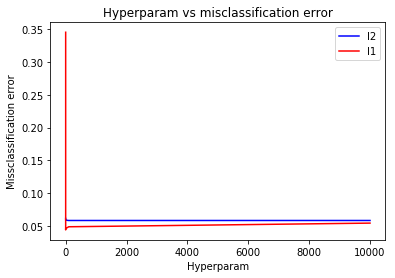

In [50]:

acc_score_l2= BOW_l2_clf_using_grid.cv_results_.get('mean_test_score')
error_l2 = [1-x for x in acc_score_l2]

acc_score_l1= BOW_l1_clf_using_grid.cv_results_.get('mean_test_score')
error_l1 = [1-x for x in acc_score_l1]

hyperparam = np.array( [10**-4, 10**-2, 10**0, 10**2, 10**4] )

plt.plot(hyperparam ,error_l2 ,'b', label="l2" )
plt.plot(hyperparam ,error_l1 ,'r', label="l1" )
plt.xlabel('Hyperparam')
plt.ylabel('Missclassification error')
plt.title('Hyperparam vs misclassification error')
plt.legend()
plt.show()

hyperparam lambda for l2 reg: {'C': 100}
Test accuracy:  0.9511681903932665
Train accuracy:  0.9999918691915536
              precision    recall  f1-score   support

          -1       0.93      0.29      0.45      3702
           1       0.91      1.00      0.95     26298

   micro avg       0.91      0.91      0.91     30000
   macro avg       0.92      0.65      0.70     30000
weighted avg       0.91      0.91      0.89     30000



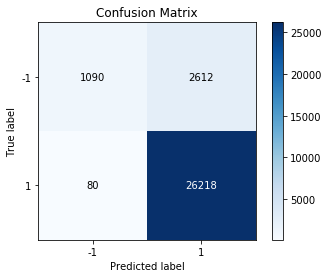

In [51]:
# best hyperparam for l2 reg
print("hyperparam lambda for l2 reg:" ,BOW_l2_clf_using_grid.best_params_ )
# test accuracy
print('Test accuracy: ',BOW_l2_clf_using_grid.score(bow_std_X_test_matrix , Y_test))
# train accuracy
print('Train accuracy: ',BOW_l2_clf_using_grid.score(bow_std_X_train_matrix , Y_train))

test_prediction = BOW_l2_clf_using_grid.predict(bow_std_X_test_matrix)
print(classification_report(Y_test, test_prediction))
import scikitplot.metrics as sciplot
sciplot.plot_confusion_matrix(Y_test, test_prediction)
plt.show()



hyperparam lambda for l1 reg: {'C': 0.01}
Test accuracy:  0.9652178752295619
Train accuracy:  0.9999918691915536
              precision    recall  f1-score   support

          -1       0.88      0.57      0.69      3702
           1       0.94      0.99      0.97     26298

   micro avg       0.94      0.94      0.94     30000
   macro avg       0.91      0.78      0.83     30000
weighted avg       0.93      0.94      0.93     30000



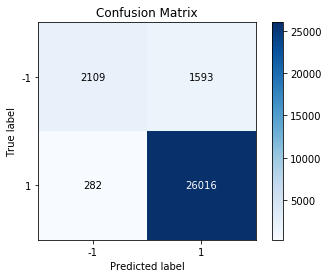

In [52]:
# best hyperparam for l1 reg
print("hyperparam lambda for l1 reg:" ,BOW_l1_clf_using_grid.best_params_ )
# test accuracy
print('Test accuracy: ',BOW_l1_clf_using_grid.score(bow_std_X_test_matrix , Y_test))
# train accuracy
print('Train accuracy: ',BOW_l1_clf_using_grid.score(bow_std_X_train_matrix , Y_train))

test_prediction = BOW_l1_clf_using_grid.predict(bow_std_X_test_matrix)
print(classification_report(Y_test, test_prediction))
import scikitplot.metrics as sciplot
sciplot.plot_confusion_matrix(Y_test, test_prediction)
plt.show()

### Randomized Search

In [57]:
tuned_parameters = {'C': [0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]}
# grid search
LR_model = LogisticRegression(penalty = 'l2')
tscv = TimeSeriesSplit(n_splits=10)
BOW_l2_clf_using_random = RandomizedSearchCV(LR_model, tuned_parameters, cv = tscv,scoring='f1' , n_jobs = -1)
BOW_l2_clf_using_random.fit(bow_std_X_train_matrix , Y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
          error_score='raise-deprecating',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='f1', verbose=0)

In [58]:
cv_score = list(BOW_l2_clf_using_random.cv_results_.get('mean_test_score'))
C_values = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
for i in range(len(cv_score)):
    print('f1_score for each C = ',C_values[i],'is ',cv_score[i] )

f1_score for each C =  0.0001 is  0.9389320263311436
f1_score for each C =  0.001 is  0.9397189415746331
f1_score for each C =  0.01 is  0.9402431112583883
f1_score for each C =  0.1 is  0.9407792814382018
f1_score for each C =  1 is  0.9415790948432426
f1_score for each C =  10 is  0.9419643796582562
f1_score for each C =  100 is  0.94205938278329
f1_score for each C =  1000 is  0.9420591431634864
f1_score for each C =  10000 is  0.9420511548190318
f1_score for each C =  100000 is  0.9420501446824505


In [59]:
LR_model_l1 = LogisticRegression(penalty = 'l1')
tscv = TimeSeriesSplit(n_splits=10)
BOW_l1_clf_using_random = RandomizedSearchCV(LR_model_l1, tuned_parameters, cv = tscv,scoring='f1' , n_jobs = -1)
BOW_l1_clf_using_random.fit(bow_std_X_train_matrix , Y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
          error_score='raise-deprecating',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='f1', verbose=0)

In [60]:
cv_score = list(BOW_l1_clf_using_random.cv_results_.get('mean_test_score'))
C_values = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
for i in range(len(cv_score)):
    print('f1_score for each C = ',C_values[i],'is ',cv_score[i] )

f1_score for each C =  0.0001 is  0.6542761024441202
f1_score for each C =  0.001 is  0.9390408905313555
f1_score for each C =  0.01 is  0.9564758714067575
f1_score for each C =  0.1 is  0.9549666386004614
f1_score for each C =  1 is  0.9544172481806655
f1_score for each C =  10 is  0.9555405873499886
f1_score for each C =  100 is  0.9513290734198615
f1_score for each C =  1000 is  0.9482673541237344
f1_score for each C =  10000 is  0.9453766736592815
f1_score for each C =  100000 is  0.9454375569296218


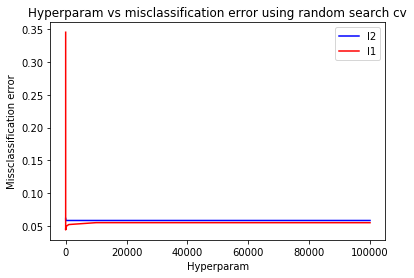

In [61]:
acc_score_l2= BOW_l2_clf_using_random.cv_results_.get('mean_test_score')
error_l2 = [1-x for x in acc_score_l2]

acc_score_l1= BOW_l1_clf_using_random.cv_results_.get('mean_test_score')
error_l1 = [1-x for x in acc_score_l1]

hyperparam = np.array( [0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000] )

plt.plot(hyperparam ,error_l2 ,'b', label="l2" )
plt.plot(hyperparam ,error_l1 ,'r', label="l1" )
plt.xlabel('Hyperparam')
plt.ylabel('Missclassification error')
plt.title('Hyperparam vs misclassification error using random search cv')
plt.legend()
plt.show()

hyperparam lambda for l2 reg: {'C': 100}
Test accuracy:  0.9511681903932665
Train accuracy:  0.9999918691915536
              precision    recall  f1-score   support

          -1       0.93      0.29      0.45      3702
           1       0.91      1.00      0.95     26298

   micro avg       0.91      0.91      0.91     30000
   macro avg       0.92      0.65      0.70     30000
weighted avg       0.91      0.91      0.89     30000



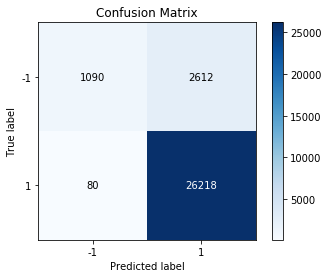

In [62]:
# best hyperparam for l2 reg
print("hyperparam lambda for l2 reg:" ,BOW_l2_clf_using_random.best_params_ )
# test accuracy
print('Test accuracy: ',BOW_l2_clf_using_random.score(bow_std_X_test_matrix , Y_test))
# train accuracy
print('Train accuracy: ',BOW_l2_clf_using_random.score(bow_std_X_train_matrix , Y_train))

test_prediction = BOW_l2_clf_using_random.predict(bow_std_X_test_matrix)
print(classification_report(Y_test, test_prediction))
import scikitplot.metrics as sciplot
sciplot.plot_confusion_matrix(Y_test, test_prediction)
plt.show()

hyperparam lambda for l1 reg: {'C': 0.01}
Test accuracy:  0.9650886695852192
Train accuracy:  0.9999918691915536
              precision    recall  f1-score   support

          -1       0.88      0.57      0.69      3702
           1       0.94      0.99      0.97     26298

   micro avg       0.94      0.94      0.94     30000
   macro avg       0.91      0.78      0.83     30000
weighted avg       0.93      0.94      0.93     30000



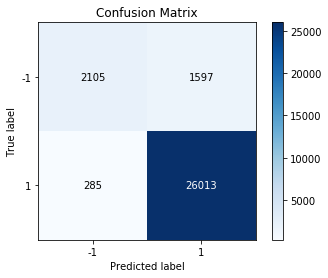

In [63]:
# best hyperparam for l1 reg
print("hyperparam lambda for l1 reg:" ,BOW_l1_clf_using_random.best_params_ )
# test accuracy
print('Test accuracy: ',BOW_l1_clf_using_random.score(bow_std_X_test_matrix , Y_test))
# train accuracy
print('Train accuracy: ',BOW_l1_clf_using_random.score(bow_std_X_train_matrix , Y_train))

test_prediction = BOW_l1_clf_using_random.predict(bow_std_X_test_matrix)
print(classification_report(Y_test, test_prediction))
import scikitplot.metrics as sciplot
sciplot.plot_confusion_matrix(Y_test, test_prediction)
plt.show()

 ### Checking how sparsity and accuracy changes with lambda for l1 reg****

In [64]:
C = [100,10,0.1,0.01,0.001]
acc=[]
non_zero_weight = []

for val in C:
    model = LogisticRegression(C= val, penalty= 'l1')
    model.fit(bow_std_X_train_matrix,Y_train)
    prediction = model.predict(bow_std_X_test_matrix)
    non_zero_weight.append(np.count_nonzero(model.coef_))
    acc.append(accuracy_score(Y_test, prediction)*100)
    print('______________________________________________________________________________')
    print('C = ' , val)
    print(classification_report(Y_test, prediction))
    print('______________________________________________________________________________')
    

______________________________________________________________________________
C =  100
              precision    recall  f1-score   support

          -1       0.92      0.44      0.59      3702
           1       0.93      0.99      0.96     26298

   micro avg       0.93      0.93      0.93     30000
   macro avg       0.92      0.71      0.77     30000
weighted avg       0.92      0.93      0.91     30000

______________________________________________________________________________
______________________________________________________________________________
C =  10
              precision    recall  f1-score   support

          -1       0.92      0.53      0.68      3702
           1       0.94      0.99      0.97     26298

   micro avg       0.94      0.94      0.94     30000
   macro avg       0.93      0.76      0.82     30000
weighted avg       0.94      0.94      0.93     30000

______________________________________________________________________________
_____________

In [65]:
# summary
print('C              ' , C)
print('accuracy       ',acc)
print('non zero weight' ,non_zero_weight )

C               [100, 10, 0.1, 0.01, 0.001]
accuracy        [92.54666666666667, 93.69, 93.63666666666667, 93.73333333333333, 90.16999999999999]
non zero weight [261822, 74757, 38786, 24545, 67]


### Observation
Sparsity increases with increasing value of lambda.

## Pertubation  Test

In [66]:

model = LogisticRegression(C= 10, penalty= 'l2')
model.fit(bow_std_X_train_matrix,Y_train)
wv_before_noise = model.coef_
print('weight vector before noise',wv_before_noise)

# adding noise
mu, sigma = 0, 0.0001 
noise = np.random.normal(mu, sigma, 1) 
noise

matrix_with_noise  = bow_std_X_train_matrix
matrix_with_noise.data = matrix_with_noise.data + noise
model.fit(matrix_with_noise, Y_train)
wv_after_noise = model.coef_
weight_change = np.abs(((wv_before_noise - wv_after_noise)+0.0001)/(wv_before_noise+0.0001) )*100

weight vector before noise [[ 0.00122589  0.00035043  0.00138322 ... -0.00112518  0.00034157
   0.16379297]]


In [67]:
print(len(weight_change[0]))

923116


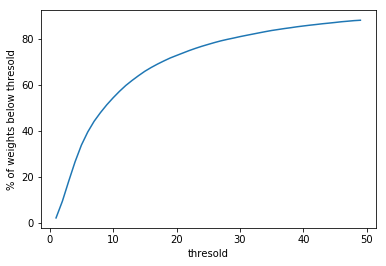

In [68]:
# using elbow method to identify thresold

l1 =[ range(1,50)]

count = []
for i in range(1,50):
    c = np.any(j<i for j in weight_change)
    count.append(sum(sum(c)) / (len(weight_change[0]))*100)

plt.plot(range(1,50) , count)
plt.xlabel('thresold')
plt.ylabel('% of weights below thresold')
plt.show()        

In [69]:
# number of weights where weight change is less than 20%
print(weight_change[np.where(weight_change < 20)].size/len(weight_change[0]))
# number of weights where weight change is less than 30%
print(weight_change[np.where(weight_change < 30)].size/len(weight_change[0]))
# number of weights where weight change is less than 50%
print(weight_change[np.where(weight_change < 50)].size/len(weight_change[0]))

0.7271870490815889
0.8092222429250495
0.882991953340642


approx 10.5% of wieghts has weight change of more than 50%. hence multicollinearty exits

### Observation
About 159k wieghts changed by more than 20%  hence  

### Feature Importance

In [70]:
#Source:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers
def show_most_informative_features(vectorizer, clf, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\tNegative\t\tPostive")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s"%(coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(count_vect , model)

		Negative		Postive
________________________________________________________________________________________________
	-0.1266	not worth      		0.4101	great          
	-0.1100	not good       		0.3277	love           
	-0.0864	one hous       		0.2883	good           
	-0.0850	not cup        		0.2625	best           
	-0.0826	disappoint     		0.1933	delici         
	-0.0773	not buy        		0.1787	excel          
	-0.0747	store groceri  		0.1548	great tast     
	-0.0739	think order    		0.1455	favorit        
	-0.0727	worth not      		0.1453	yummi          
	-0.0715	terribl        		0.1445	great product  


# TF-IDF

In [90]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
# Transforming train/test data into tf-idf
tf_idf_X_train_matrix = tf_idf_vect.fit_transform(X_train.values)
print(tf_idf_X_train_matrix.shape)
tf_idf_X_test_matrix = tf_idf_vect.transform(X_test.values)
print(tf_idf_X_test_matrix.shape)

(70000, 923115)
(30000, 923115)


In [91]:
tf_idf_X_train_matrix = hstack((tf_idf_X_train_matrix,np.array(len_train)[:,None]))
tf_idf_X_test_matrix = hstack((tf_idf_X_test_matrix,np.array(len_test)[:,None]))

In [92]:
tfidf_std_X_train_matrix = std_data(tf_idf_X_train_matrix)
tfidf_std_X_test_matrix = std_data(tf_idf_X_test_matrix)

In [88]:
tfidf_std_X_test_matrix.shape

(30000, 923116)

###  Grid Search Cross Validation

In [74]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
# grid search
LR_model = LogisticRegression(penalty = 'l2')
tscv = TimeSeriesSplit(n_splits=10)
tfidf_l2_clf_using_grid = GridSearchCV(LR_model, tuned_parameters, cv = tscv,scoring='f1' , n_jobs = -1)
tfidf_l2_clf_using_grid.fit(tfidf_std_X_train_matrix , Y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'C': [0.0001, 0.01, 1, 100, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [75]:
cv_score = list(tfidf_l2_clf_using_grid.cv_results_.get('mean_test_score'))
C_values = [10**-4, 10**-2, 10**0, 10**2, 10**4]
for i in range(len(cv_score)):
    print('f1_score for each C = ',C_values[i],'is ',cv_score[i] )

f1_score for each C =  0.0001 is  0.9381740684348028
f1_score for each C =  0.01 is  0.9393751333966973
f1_score for each C =  1 is  0.9399542267082666
f1_score for each C =  100 is  0.9404927851844914
f1_score for each C =  10000 is  0.9404770429554553


In [76]:
LR_model_l1 = LogisticRegression(penalty = 'l1')
tscv = TimeSeriesSplit(n_splits=10)
tfidf_l1_clf_using_grid = GridSearchCV(LR_model_l1, tuned_parameters, cv = tscv,scoring='f1' , n_jobs=-1)
tfidf_l1_clf_using_grid.fit(tfidf_std_X_train_matrix , Y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'C': [0.0001, 0.01, 1, 100, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [77]:
cv_score = list(tfidf_l1_clf_using_grid.cv_results_.get('mean_test_score'))
C_values = [10**-4, 10**-2, 10**0, 10**2, 10**4]
for i in range(len(cv_score)):
    print('f1_score for each C = ',C_values[i],'is ',cv_score[i] )

f1_score for each C =  0.0001 is  0.6542761024441202
f1_score for each C =  0.01 is  0.9576271236781425
f1_score for each C =  1 is  0.9562432371259451
f1_score for each C =  100 is  0.9462859854765491
f1_score for each C =  10000 is  0.9440583010922886


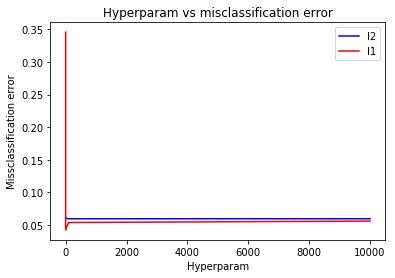

In [78]:
acc_score_l2= tfidf_l2_clf_using_grid.cv_results_.get('mean_test_score')
error_l2 = [1-x for x in acc_score_l2]

acc_score_l1= tfidf_l1_clf_using_grid.cv_results_.get('mean_test_score')
error_l1 = [1-x for x in acc_score_l1]

hyperparam = np.array( [10**-4, 10**-2, 10**0, 10**2, 10**4] )

plt.plot(hyperparam ,error_l2 ,'b', label="l2" )
plt.plot(hyperparam ,error_l1 ,'r', label="l1" )
plt.xlabel('Hyperparam')
plt.ylabel('Missclassification error')
plt.title('Hyperparam vs misclassification error')
plt.legend()
plt.show()

In [80]:
tfidf_std_X_test_matrix.shape

(30000, 923115)

hyperparam lambda for l2 reg: {'C': 100}
Test accuracy:  0.9478602872194558
Train accuracy:  0.9999918690593315
              precision    recall  f1-score   support

          -1       0.97      0.23      0.37      3702
           1       0.90      1.00      0.95     26298

   micro avg       0.90      0.90      0.90     30000
   macro avg       0.93      0.61      0.66     30000
weighted avg       0.91      0.90      0.88     30000



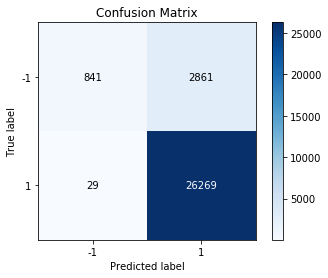

In [93]:
# best hyperparam for l2 reg
print("hyperparam lambda for l2 reg:" ,tfidf_l2_clf_using_grid.best_params_ )
# test accuracy
print('Test accuracy: ',tfidf_l2_clf_using_grid.score(tfidf_std_X_test_matrix , Y_test))
# train accuracy
print('Train accuracy: ',tfidf_l2_clf_using_grid.score(tfidf_std_X_train_matrix , Y_train))

test_prediction = tfidf_l2_clf_using_grid.predict(tfidf_std_X_test_matrix)
print(classification_report(Y_test, test_prediction))
import scikitplot.metrics as sciplot
sciplot.plot_confusion_matrix(Y_test, test_prediction)
plt.show()

hyperparam lambda for l1 reg: {'C': 0.01}
Test accuracy:  0.9671211502024742
Train accuracy:  0.9998699208142957
              precision    recall  f1-score   support

          -1       0.89      0.59      0.71      3702
           1       0.95      0.99      0.97     26298

   micro avg       0.94      0.94      0.94     30000
   macro avg       0.92      0.79      0.84     30000
weighted avg       0.94      0.94      0.94     30000



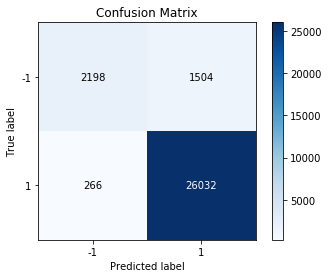

In [94]:
print("hyperparam lambda for l1 reg:" ,tfidf_l1_clf_using_grid.best_params_ )
# test accuracy
print('Test accuracy: ',tfidf_l1_clf_using_grid.score(tfidf_std_X_test_matrix , Y_test))
# train accuracy
print('Train accuracy: ',tfidf_l1_clf_using_grid.score(tfidf_std_X_train_matrix , Y_train))

test_prediction = tfidf_l1_clf_using_grid.predict(tfidf_std_X_test_matrix)
print(classification_report(Y_test, test_prediction))
import scikitplot.metrics as sciplot
sciplot.plot_confusion_matrix(Y_test, test_prediction)
plt.show()

## Randomized Serach

In [95]:
tuned_parameters = {'C': [0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]}
# grid search
LR_model = LogisticRegression(penalty = 'l2')
tscv = TimeSeriesSplit(n_splits=10)
tfidf_l2_clf_using_random = RandomizedSearchCV(LR_model, tuned_parameters, cv = tscv,scoring='f1' , n_jobs = -1)
tfidf_l2_clf_using_random.fit(tfidf_std_X_train_matrix , Y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
          error_score='raise-deprecating',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='f1', verbose=0)

In [96]:
cv_score = list(tfidf_l2_clf_using_random.cv_results_.get('mean_test_score'))
C_values = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
for i in range(len(cv_score)):
    print('f1_score for each C = ',C_values[i],'is ',cv_score[i] )

f1_score for each C =  0.0001 is  0.9381740684348028
f1_score for each C =  0.001 is  0.9390236824064357
f1_score for each C =  0.01 is  0.9393751333966973
f1_score for each C =  0.1 is  0.9395932670888872
f1_score for each C =  1 is  0.9399542267082666
f1_score for each C =  10 is  0.9403493169153093
f1_score for each C =  100 is  0.9404927851844914
f1_score for each C =  1000 is  0.9404690254685735
f1_score for each C =  10000 is  0.9404770429554553
f1_score for each C =  100000 is  0.940453176937863


In [97]:
LR_model_l1 = LogisticRegression(penalty = 'l1')
tscv = TimeSeriesSplit(n_splits=10)
tfidf_l1_clf_using_random = RandomizedSearchCV(LR_model_l1, tuned_parameters, cv = tscv,scoring='f1' , n_jobs = -1)
tfidf_l1_clf_using_random.fit(tfidf_std_X_train_matrix , Y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
          error_score='raise-deprecating',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='f1', verbose=0)

In [98]:
cv_score = list(tfidf_l1_clf_using_random.cv_results_.get('mean_test_score'))
C_values = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
for i in range(len(cv_score)):
    print('f1_score for each C = ',C_values[i],'is ',cv_score[i] )

f1_score for each C =  0.0001 is  0.6542761024441202
f1_score for each C =  0.001 is  0.939466890031485
f1_score for each C =  0.01 is  0.9576014512290092
f1_score for each C =  0.1 is  0.9559312572369503
f1_score for each C =  1 is  0.9560782367922956
f1_score for each C =  10 is  0.9511561234926991
f1_score for each C =  100 is  0.9460629655018574
f1_score for each C =  1000 is  0.9452585823042488
f1_score for each C =  10000 is  0.9431537414298378
f1_score for each C =  100000 is  0.9419248925285107


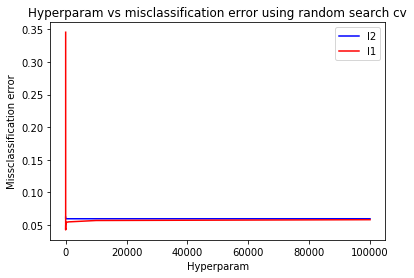

In [99]:
acc_score_l2= tfidf_l2_clf_using_random.cv_results_.get('mean_test_score')
error_l2 = [1-x for x in acc_score_l2]

acc_score_l1= tfidf_l1_clf_using_random.cv_results_.get('mean_test_score')
error_l1 = [1-x for x in acc_score_l1]

hyperparam = np.array( [0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000] )

plt.plot(hyperparam ,error_l2 ,'b', label="l2" )
plt.plot(hyperparam ,error_l1 ,'r', label="l1" )
plt.xlabel('Hyperparam')
plt.ylabel('Missclassification error')
plt.title('Hyperparam vs misclassification error using random search cv')
plt.legend()
plt.show()

hyperparam lambda for l2 reg: {'C': 100}
Test accuracy:  0.9478602872194558
Train accuracy:  0.9999918690593315
              precision    recall  f1-score   support

          -1       0.97      0.23      0.37      3702
           1       0.90      1.00      0.95     26298

   micro avg       0.90      0.90      0.90     30000
   macro avg       0.93      0.61      0.66     30000
weighted avg       0.91      0.90      0.88     30000



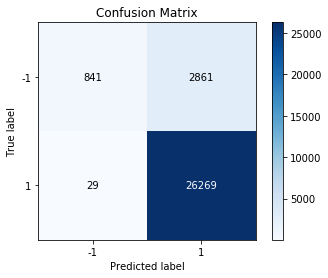

In [100]:
# best hyperparam for l2 reg
print("hyperparam lambda for l2 reg:" ,tfidf_l2_clf_using_random.best_params_ )
# test accuracy
print('Test accuracy: ',tfidf_l2_clf_using_random.score(tfidf_std_X_test_matrix , Y_test))
# train accuracy
print('Train accuracy: ',tfidf_l2_clf_using_random.score(tfidf_std_X_train_matrix , Y_train))

test_prediction = tfidf_l2_clf_using_random.predict(tfidf_std_X_test_matrix)
print(classification_report(Y_test, test_prediction))
import scikitplot.metrics as sciplot
sciplot.plot_confusion_matrix(Y_test, test_prediction)
plt.show()

hyperparam lambda for l1 reg: {'C': 0.01}
Test accuracy:  0.9671546407074385
Train accuracy:  0.9999918690593315
              precision    recall  f1-score   support

          -1       0.89      0.59      0.71      3702
           1       0.95      0.99      0.97     26298

   micro avg       0.94      0.94      0.94     30000
   macro avg       0.92      0.79      0.84     30000
weighted avg       0.94      0.94      0.94     30000



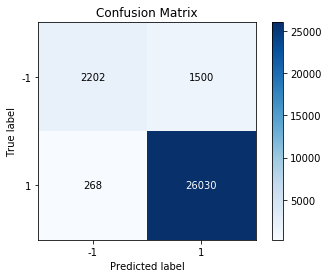

In [101]:
# best hyperparam for l1 reg
print("hyperparam lambda for l1 reg:" ,tfidf_l1_clf_using_random.best_params_ )
# test accuracy
print('Test accuracy: ',tfidf_l1_clf_using_random.score(tfidf_std_X_test_matrix , Y_test))
# train accuracy
print('Train accuracy: ',tfidf_l1_clf_using_random.score(tfidf_std_X_train_matrix , Y_train))

test_prediction = tfidf_l1_clf_using_random.predict(tfidf_std_X_test_matrix)
print(classification_report(Y_test, test_prediction))
import scikitplot.metrics as sciplot
sciplot.plot_confusion_matrix(Y_test, test_prediction)
plt.show()


### checking how sparsity changes when lambda changes

In [102]:
C = [100,10,0.1,0.01,0.001]
acc=[]
non_zero_weight = []

for val in C:
    model = LogisticRegression(C= val, penalty= 'l1')
    model.fit(tfidf_std_X_train_matrix,Y_train)
    prediction = model.predict(tfidf_std_X_test_matrix)
    non_zero_weight.append(np.count_nonzero(model.coef_))
    acc.append(accuracy_score(Y_test, prediction)*100)
    print('______________________________________________________________________________')
    print('C = ' , val)
    print(classification_report(Y_test, prediction))
    print('______________________________________________________________________________')

______________________________________________________________________________
C =  100
              precision    recall  f1-score   support

          -1       0.95      0.32      0.48      3702
           1       0.91      1.00      0.95     26298

   micro avg       0.91      0.91      0.91     30000
   macro avg       0.93      0.66      0.72     30000
weighted avg       0.92      0.91      0.89     30000

______________________________________________________________________________
______________________________________________________________________________
C =  10
              precision    recall  f1-score   support

          -1       0.94      0.46      0.62      3702
           1       0.93      1.00      0.96     26298

   micro avg       0.93      0.93      0.93     30000
   macro avg       0.93      0.73      0.79     30000
weighted avg       0.93      0.93      0.92     30000

______________________________________________________________________________
_____________

In [103]:
print('C              ' , C)
print('accuracy       ',acc)
print('non zero weight' ,non_zero_weight )

C               [100, 10, 0.1, 0.01, 0.001]
accuracy        [91.42333333333333, 93.0, 93.82000000000001, 94.1, 90.36333333333333]
non zero weight [240281, 78989, 39047, 22555, 76]


### Observation:
Sparsity increases as value of lambda increases for l1 regulizer while accuracy first increased and then decreased.

### Pertubation

In [104]:
model = LogisticRegression(C= 10, penalty= 'l2')
model.fit(tfidf_std_X_train_matrix,Y_train)
wv_before_noise = model.coef_
print('weight vector before noise',wv_before_noise)

# adding noise
mu, sigma = 0, 0.00001 
noise = np.random.normal(mu, sigma, 1) 
noise

matrix_with_noise  = tfidf_std_X_train_matrix
matrix_with_noise.data = matrix_with_noise.data + noise
model.fit(matrix_with_noise, Y_train)
wv_after_noise = model.coef_
weight_change = np.abs(((wv_before_noise - wv_after_noise)+0.00001)/(wv_before_noise+0.00001) )*100

weight vector before noise [[0.00171056 0.00095295 0.00142134 ... 0.0005425  0.00051023 0.1101261 ]]


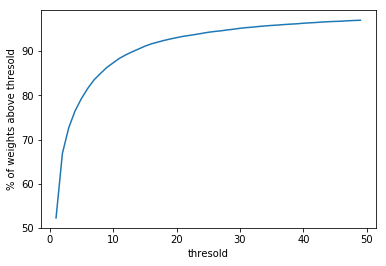

In [105]:
l1 =[ range(1,50)]

count = []
for i in range(1,50):
    c = np.any(j<i for j in weight_change)
    count.append(sum(sum(c)) / (len(weight_change[0]))*100)

plt.plot(range(1,50) , count)
plt.xlabel('thresold')
plt.ylabel('% of weights above thresold')
plt.show()       

In [106]:
# number of weights where weight change is less than 20%
print(weight_change[np.where(weight_change < 20)].size/len(weight_change[0]))
# number of weights where weight change is less than 30%
print(weight_change[np.where(weight_change < 30)].size/len(weight_change[0]))
# number of weights where weight change is less than 50%
print(weight_change[np.where(weight_change < 50)].size/len(weight_change[0]))

0.9301507069534056
0.9513463096728905
0.9701911785734404


approx 99% of weights has weight change less than 50% hence less multicollinearity exit

### Feature Importance

In [107]:
show_most_informative_features(tf_idf_vect , model)

		Negative		Postive
________________________________________________________________________________________________
	-0.0871	not good       		0.2710	great          
	-0.0837	not worth      		0.2310	love           
	-0.0805	disappoint     		0.2064	good           
	-0.0718	not buy        		0.1897	best           
	-0.0696	worst          		0.1450	delici         
	-0.0687	terribl        		0.1289	excel          
	-0.0667	would not      		0.1127	favorit        
	-0.0654	not recommend  		0.1068	product        
	-0.0617	second least   		0.1047	find           
	-0.0614	wast money     		0.1001	yummi          


### Avg Word2Vec

In [108]:
list_of_sent=[]
for sent in X_train.values:
    list_of_sent.append(sent.split())
    
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4) 

sent_vectors = [];
for sent in list_of_sent:
    sent_vec = np.zeros(50)
    cnt_words =0;
    for word in sent:
        if word in w2v_model:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

w2vec_X_train_matrix = np.array(sent_vectors)

In [112]:
list_of_sent=[]
for sent in X_test.values:
    list_of_sent.append(sent.split())
    
sent_vectors = [];
for sent in list_of_sent:
    sent_vec = np.zeros(50)
    cnt_words =0;
    for word in sent:
        if word in w2v_model:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
    
w2vec_X_test_matrix = np.array(sent_vectors)


In [116]:
# standrizing data
w2vec_std_X_train_matrix = std_data(w2vec_X_train_matrix)
w2vec_std_X_test_matrix = std_data(w2vec_X_test_matrix)

### Grid Search

In [130]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
# grid search
LR_model = LogisticRegression(penalty = 'l2')
tscv = TimeSeriesSplit(n_splits=10)
w2vec_l2_clf_using_grid = GridSearchCV(LR_model, tuned_parameters, cv = tscv,scoring='f1' , n_jobs = -1)
w2vec_l2_clf_using_grid.fit(w2vec_std_X_train_matrix , Y_train)

cv_score = list(w2vec_l2_clf_using_grid.cv_results_.get('mean_test_score'))
C_values = [10**-4, 10**-2, 10**0, 10**2, 10**4]
for i in range(len(cv_score)):
    print('f1_score for each C = ',C_values[i],'is ',cv_score[i] )


f1_score for each C =  0.0001 is  0.9376977617563949
f1_score for each C =  0.01 is  0.9547488731626522
f1_score for each C =  1 is  0.9551524731730346
f1_score for each C =  100 is  0.9552048166744035
f1_score for each C =  10000 is  0.9551964790576227


In [131]:
LR_model_l1 = LogisticRegression(penalty = 'l1')
tscv = TimeSeriesSplit(n_splits=10)
w2vec_l1_clf_using_grid = GridSearchCV(LR_model_l1, tuned_parameters, cv = tscv,scoring='f1' , n_jobs=-1)
w2vec_l1_clf_using_grid.fit(w2vec_std_X_train_matrix , Y_train)

cv_score = list(w2vec_l1_clf_using_grid.cv_results_.get('mean_test_score'))
C_values = [10**-4, 10**-2, 10**0, 10**2, 10**4]
for i in range(len(cv_score)):
    print('f1_score for each C = ',C_values[i],'is ',cv_score[i] )

f1_score for each C =  0.0001 is  0.745496271755618
f1_score for each C =  0.01 is  0.9524627242484321
f1_score for each C =  1 is  0.9551382055058995
f1_score for each C =  100 is  0.9551788991994292
f1_score for each C =  10000 is  0.955196464518527


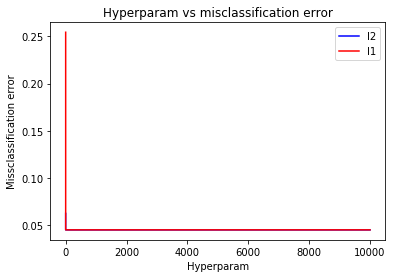

In [118]:
acc_score_l2= w2vec_l2_clf_using_grid.cv_results_.get('mean_test_score')
error_l2 = [1-x for x in acc_score_l2]

acc_score_l1= w2vec_l1_clf_using_grid.cv_results_.get('mean_test_score')
error_l1 = [1-x for x in acc_score_l1]

hyperparam = np.array( [10**-4, 10**-2, 10**0, 10**2, 10**4] )

plt.plot(hyperparam ,error_l2 ,'b', label="l2" )
plt.plot(hyperparam ,error_l1 ,'r', label="l1" )
plt.xlabel('Hyperparam')
plt.ylabel('Missclassification error')
plt.title('Hyperparam vs misclassification error')
plt.legend()
plt.show()

hyperparam lambda for l2 reg: {'C': 100}
Test accuracy:  0.9540334742054996
Train accuracy:  0.9557589747671734
              precision    recall  f1-score   support

          -1       0.74      0.52      0.61      3702
           1       0.93      0.97      0.95     26298

   micro avg       0.92      0.92      0.92     30000
   macro avg       0.84      0.74      0.78     30000
weighted avg       0.91      0.92      0.91     30000



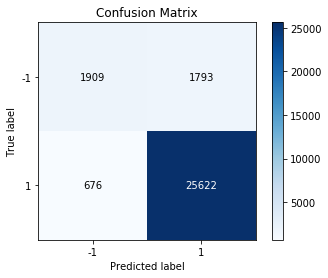

In [119]:
# best hyperparam for l2 reg
print("hyperparam lambda for l2 reg:" ,w2vec_l2_clf_using_grid.best_params_ )
# test accuracy
print('Test accuracy: ',w2vec_l2_clf_using_grid.score(w2vec_std_X_test_matrix , Y_test))
# train accuracy
print('Train accuracy: ',w2vec_l2_clf_using_grid.score(w2vec_std_X_train_matrix , Y_train))

test_prediction = w2vec_l2_clf_using_grid.predict(w2vec_std_X_test_matrix)
print(classification_report(Y_test, test_prediction))
import scikitplot.metrics as sciplot
sciplot.plot_confusion_matrix(Y_test, test_prediction)
plt.show()

hyperparam lambda for l1 reg: {'C': 1}
Test accuracy:  0.9540174249757987
Train accuracy:  0.9557596790626592
              precision    recall  f1-score   support

          -1       0.74      0.52      0.61      3702
           1       0.93      0.97      0.95     26298

   micro avg       0.92      0.92      0.92     30000
   macro avg       0.84      0.74      0.78     30000
weighted avg       0.91      0.92      0.91     30000



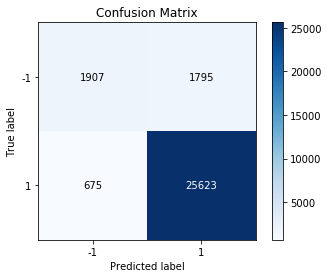

In [120]:
print("hyperparam lambda for l1 reg:" ,w2vec_l1_clf_using_grid.best_params_ )
# test accuracy
print('Test accuracy: ',w2vec_l1_clf_using_grid.score(w2vec_std_X_test_matrix , Y_test))
# train accuracy
print('Train accuracy: ',w2vec_l1_clf_using_grid.score(w2vec_std_X_train_matrix , Y_train))

test_prediction = w2vec_l1_clf_using_grid.predict(w2vec_std_X_test_matrix)
print(classification_report(Y_test, test_prediction))
import scikitplot.metrics as sciplot
sciplot.plot_confusion_matrix(Y_test, test_prediction)
plt.show()

 ### Randomized Search

In [132]:
tuned_parameters = {'C': [0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]}
# grid search
LR_model = LogisticRegression(penalty = 'l2')
tscv = TimeSeriesSplit(n_splits=10)
w2vec_l2_clf_using_random = RandomizedSearchCV(LR_model, tuned_parameters, cv = tscv,scoring='f1' , n_jobs = -1)
w2vec_l2_clf_using_random.fit(w2vec_std_X_train_matrix , Y_train)

cv_score = list(w2vec_l2_clf_using_random.cv_results_.get('mean_test_score'))
C_values = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
for i in range(len(cv_score)):
    print('f1_score for each C = ',C_values[i],'is ',cv_score[i] )

print('--------------------------------------------------------------------------------------------')
LR_model_l1 = LogisticRegression(penalty = 'l1')
tscv = TimeSeriesSplit(n_splits=10)
w2vec_l1_clf_using_random = RandomizedSearchCV(LR_model_l1, tuned_parameters, cv = tscv,scoring='f1' , n_jobs = -1)
w2vec_l1_clf_using_random.fit(w2vec_std_X_train_matrix , Y_train)

cv_score = list(w2vec_l1_clf_using_random.cv_results_.get('mean_test_score'))
C_values = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
for i in range(len(cv_score)):
    print('f1_score for each C = ',C_values[i],'is ',cv_score[i] )


f1_score for each C =  0.0001 is  0.9376977617563949
f1_score for each C =  0.001 is  0.9502917610069528
f1_score for each C =  0.01 is  0.9547488731626522
f1_score for each C =  0.1 is  0.9552026499834799
f1_score for each C =  1 is  0.9551524731730346
f1_score for each C =  10 is  0.9551949555430072
f1_score for each C =  100 is  0.9552048166744035
f1_score for each C =  1000 is  0.9551964790576227
f1_score for each C =  10000 is  0.9551964790576227
f1_score for each C =  100000 is  0.9551964790576227
--------------------------------------------------------------------------------------------
f1_score for each C =  0.0001 is  0.745496271755618
f1_score for each C =  0.001 is  0.9397479514063568
f1_score for each C =  0.01 is  0.9524444498377826
f1_score for each C =  0.1 is  0.9549859248778372
f1_score for each C =  1 is  0.9551556764534351
f1_score for each C =  10 is  0.9551424515296122
f1_score for each C =  100 is  0.9551872777959193
f1_score for each C =  1000 is  0.955178958291

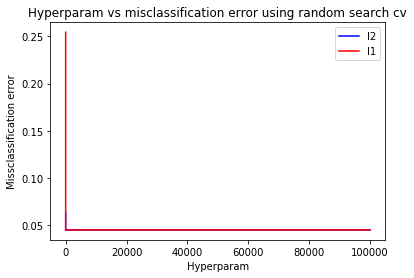

In [122]:
acc_score_l2= w2vec_l2_clf_using_random.cv_results_.get('mean_test_score')
error_l2 = [1-x for x in acc_score_l2]

acc_score_l1= w2vec_l1_clf_using_random.cv_results_.get('mean_test_score')
error_l1 = [1-x for x in acc_score_l1]

hyperparam = np.array( [0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000] )

plt.plot(hyperparam ,error_l2 ,'b', label="l2" )
plt.plot(hyperparam ,error_l1 ,'r', label="l1" )
plt.xlabel('Hyperparam')
plt.ylabel('Missclassification error')
plt.title('Hyperparam vs misclassification error using random search cv')
plt.legend()
plt.show()

hyperparam lambda for l2 reg: {'C': 100}
Test accuracy:  0.9540334742054996
Train accuracy:  0.9557589747671734
              precision    recall  f1-score   support

          -1       0.74      0.52      0.61      3702
           1       0.93      0.97      0.95     26298

   micro avg       0.92      0.92      0.92     30000
   macro avg       0.84      0.74      0.78     30000
weighted avg       0.91      0.92      0.91     30000



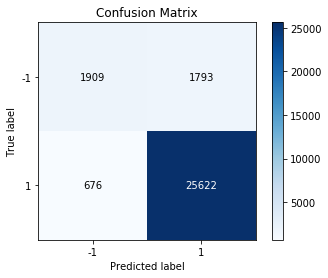

In [123]:
# best hyperparam for l2 reg
print("hyperparam lambda for l2 reg:" ,w2vec_l2_clf_using_random.best_params_ )
# test accuracy
print('Test accuracy: ',w2vec_l2_clf_using_random.score(w2vec_std_X_test_matrix , Y_test))
# train accuracy
print('Train accuracy: ',w2vec_l2_clf_using_random.score(w2vec_std_X_train_matrix , Y_train))

test_prediction = w2vec_l2_clf_using_random.predict(w2vec_std_X_test_matrix)
print(classification_report(Y_test, test_prediction))
import scikitplot.metrics as sciplot
sciplot.plot_confusion_matrix(Y_test, test_prediction)
plt.show()

hyperparam lambda for l1 reg: {'C': 10}
Test accuracy:  0.9539767649687221
Train accuracy:  0.9557589747671734
              precision    recall  f1-score   support

          -1       0.74      0.52      0.61      3702
           1       0.93      0.97      0.95     26298

   micro avg       0.92      0.92      0.92     30000
   macro avg       0.84      0.74      0.78     30000
weighted avg       0.91      0.92      0.91     30000



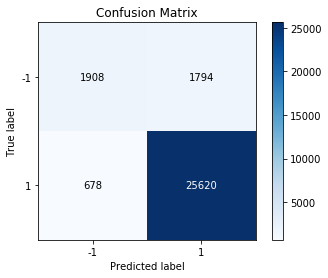

In [124]:
# best hyperparam for l1 reg
print("hyperparam lambda for l1 reg:" ,w2vec_l1_clf_using_random.best_params_ )
# test accuracy
print('Test accuracy: ',w2vec_l1_clf_using_random.score(w2vec_std_X_test_matrix , Y_test))
# train accuracy
print('Train accuracy: ',w2vec_l1_clf_using_random.score(w2vec_std_X_train_matrix , Y_train))

test_prediction = w2vec_l1_clf_using_random.predict(w2vec_std_X_test_matrix)
print(classification_report(Y_test, test_prediction))
import scikitplot.metrics as sciplot
sciplot.plot_confusion_matrix(Y_test, test_prediction)
plt.show()


### Checking how the sparsity of wieght vector changes for different values of lamda

In [125]:
C = [100,10,0.1,0.01,0.001]
acc=[]
non_zero_weight = []

for val in C:
    model = LogisticRegression(C= val, penalty= 'l1')
    model.fit(w2vec_std_X_train_matrix,Y_train)
    prediction = model.predict(w2vec_std_X_test_matrix)
    non_zero_weight.append(np.count_nonzero(model.coef_))
    acc.append(accuracy_score(Y_test, prediction)*100)
    print('______________________________________________________________________________')
    print('C = ' , val)
    print(classification_report(Y_test, prediction))
    print('______________________________________________________________________________')

______________________________________________________________________________
C =  100
              precision    recall  f1-score   support

          -1       0.74      0.52      0.61      3702
           1       0.93      0.97      0.95     26298

   micro avg       0.92      0.92      0.92     30000
   macro avg       0.84      0.74      0.78     30000
weighted avg       0.91      0.92      0.91     30000

______________________________________________________________________________
______________________________________________________________________________
C =  10
              precision    recall  f1-score   support

          -1       0.74      0.52      0.61      3702
           1       0.93      0.97      0.95     26298

   micro avg       0.92      0.92      0.92     30000
   macro avg       0.84      0.74      0.78     30000
weighted avg       0.91      0.92      0.91     30000

______________________________________________________________________________
_____________

In [126]:
print('C              ' , C)
print('accuracy       ',acc)
print('non zero weight' ,non_zero_weight )

C               [100, 10, 0.1, 0.01, 0.001]
accuracy        [91.76666666666667, 91.76666666666667, 91.77666666666666, 91.66333333333333, 89.96333333333332]
non zero weight [50, 50, 49, 44, 20]


## Tf-Idf W2Vec

In [134]:
list_of_sent=[]
for sent in X_train.values:
    list_of_sent.append(sent.split())

#w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train.values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
    
tfidf_feat = tf_idf_vect.get_feature_names()
tfidf_sent_vectors_X_train = []
row=0
for sent in list_of_sent: #list_of_sent
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent:
        if word in w2v_model:
            vec = w2v_model.wv[word]
         # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_X_train.append(sent_vec)
    row += 1

In [135]:
list_of_sent=[]
for sent in X_test.values:
    list_of_sent.append(sent.split())


tfidf_sent_vectors_X_test = [];
row=0;
for sent in list_of_sent: #list_of_sent
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent:
        if word in w2v_model:
            vec = w2v_model.wv[word]
               # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_X_test.append(sent_vec)
    row += 1


In [136]:
tfidf_w2vec_std_X_train_matrix = std_data(tfidf_sent_vectors_X_train)
tfidf_w2vec_std_X_test_matrix = std_data(tfidf_sent_vectors_X_test)

### Grid Search

In [137]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
# grid search
LR_model = LogisticRegression(penalty = 'l2')
tscv = TimeSeriesSplit(n_splits=10)
tfidf_w2vec_l2_clf_using_grid = GridSearchCV(LR_model, tuned_parameters, cv = tscv,scoring='f1' , n_jobs = -1)
tfidf_w2vec_l2_clf_using_grid.fit(tfidf_w2vec_std_X_train_matrix , Y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'C': [0.0001, 0.01, 1, 100, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [138]:
cv_score = list(tfidf_w2vec_l2_clf_using_grid.cv_results_.get('mean_test_score'))
C_values = [10**-4, 10**-2, 10**0, 10**2, 10**4]
for i in range(len(cv_score)):
    print('f1_score for each C = ',C_values[i],'is ',cv_score[i] )

f1_score for each C =  0.0001 is  0.9359200386290333
f1_score for each C =  0.01 is  0.9481963780979842
f1_score for each C =  1 is  0.9483355318571473
f1_score for each C =  100 is  0.948379731152954
f1_score for each C =  10000 is  0.948388832981235


In [140]:
LR_model_l1 = LogisticRegression(penalty = 'l1')
tscv = TimeSeriesSplit(n_splits=10)
tfidf_w2vec_l1_clf_using_grid = GridSearchCV(LR_model_l1, tuned_parameters, cv = tscv,scoring='f1' , n_jobs=-1)
tfidf_w2vec_l1_clf_using_grid.fit(tfidf_w2vec_std_X_train_matrix , Y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'C': [0.0001, 0.01, 1, 100, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [141]:
cv_score = list(tfidf_w2vec_l1_clf_using_grid.cv_results_.get('mean_test_score'))
C_values = [10**-4, 10**-2, 10**0, 10**2, 10**4]
for i in range(len(cv_score)):
    print('f1_score for each C = ',C_values[i],'is ',cv_score[i] )

f1_score for each C =  0.0001 is  0.6424943293640563
f1_score for each C =  0.01 is  0.9459797356532305
f1_score for each C =  1 is  0.9483921255231242
f1_score for each C =  100 is  0.948320252381029
f1_score for each C =  10000 is  0.9483367654836142


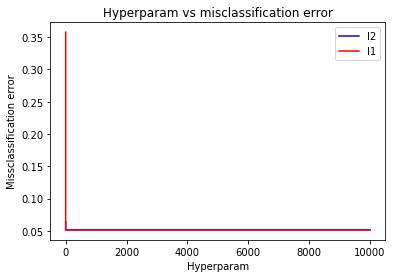

In [142]:
acc_score_l2= tfidf_w2vec_l2_clf_using_grid.cv_results_.get('mean_test_score')
error_l2 = [1-x for x in acc_score_l2]

acc_score_l1= tfidf_w2vec_l1_clf_using_grid.cv_results_.get('mean_test_score')
error_l1 = [1-x for x in acc_score_l1]

hyperparam = np.array( [10**-4, 10**-2, 10**0, 10**2, 10**4] )

plt.plot(hyperparam ,error_l2 ,'b', label="l2" )
plt.plot(hyperparam ,error_l1 ,'r', label="l1" )
plt.xlabel('Hyperparam')
plt.ylabel('Missclassification error')
plt.title('Hyperparam vs misclassification error')
plt.legend()
plt.show()

hyperparam lambda for l2 reg: {'C': 10000}
Test accuracy:  0.9479664299548096
Train accuracy:  0.9486535972472141
              precision    recall  f1-score   support

          -1       0.71      0.40      0.51      3702
           1       0.92      0.98      0.95     26298

   micro avg       0.91      0.91      0.91     30000
   macro avg       0.82      0.69      0.73     30000
weighted avg       0.89      0.91      0.89     30000



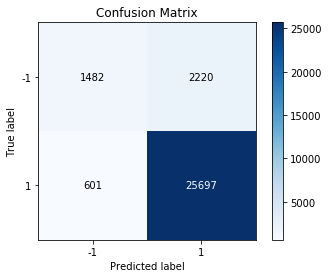

In [143]:
# best hyperparam for l2 reg
print("hyperparam lambda for l2 reg:" ,tfidf_w2vec_l2_clf_using_grid.best_params_ )
# test accuracy
print('Test accuracy: ',tfidf_w2vec_l2_clf_using_grid.score(tfidf_w2vec_std_X_test_matrix , Y_test))
# train accuracy
print('Train accuracy: ',tfidf_w2vec_l2_clf_using_grid.score(tfidf_w2vec_std_X_train_matrix , Y_train))

test_prediction = tfidf_w2vec_l2_clf_using_grid.predict(tfidf_w2vec_std_X_test_matrix)
print(classification_report(Y_test, test_prediction))
import scikitplot.metrics as sciplot
sciplot.plot_confusion_matrix(Y_test, test_prediction)
plt.show()

hyperparam lambda for l2 reg: {'C': 1}
Test accuracy:  0.9479547047323965
Train accuracy:  0.9486360013572911
              precision    recall  f1-score   support

          -1       0.71      0.40      0.51      3702
           1       0.92      0.98      0.95     26298

   micro avg       0.91      0.91      0.91     30000
   macro avg       0.82      0.69      0.73     30000
weighted avg       0.89      0.91      0.89     30000



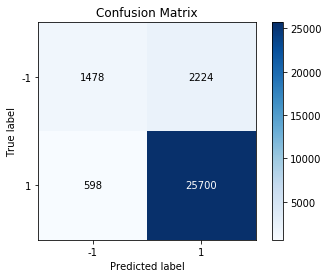

In [144]:
# best hyperparam for l1 reg
print("hyperparam lambda for l2 reg:" ,tfidf_w2vec_l1_clf_using_grid.best_params_ )
# test accuracy
print('Test accuracy: ',tfidf_w2vec_l1_clf_using_grid.score(tfidf_w2vec_std_X_test_matrix , Y_test))
# train accuracy
print('Train accuracy: ',tfidf_w2vec_l1_clf_using_grid.score(tfidf_w2vec_std_X_train_matrix , Y_train))

test_prediction = tfidf_w2vec_l1_clf_using_grid.predict(tfidf_w2vec_std_X_test_matrix)
print(classification_report(Y_test, test_prediction))
import scikitplot.metrics as sciplot
sciplot.plot_confusion_matrix(Y_test, test_prediction)
plt.show()


### Randomized Search

In [145]:
tuned_parameters = {'C': [0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]}
# grid search
LR_model = LogisticRegression(penalty = 'l2')
tscv = TimeSeriesSplit(n_splits=10)
tfidf_w2vec_l2_clf_using_random = RandomizedSearchCV(LR_model, tuned_parameters, cv = tscv,scoring='f1' , n_jobs = -1)
tfidf_w2vec_l2_clf_using_random.fit(tfidf_w2vec_std_X_train_matrix , Y_train)


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
          error_score='raise-deprecating',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='f1', verbose=0)

In [146]:
cv_score = list(tfidf_w2vec_l2_clf_using_random.cv_results_.get('mean_test_score'))
C_values = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
for i in range(len(cv_score)):
    print('f1_score for each C = ',C_values[i],'is ',cv_score[i] )

f1_score for each C =  0.0001 is  0.9359200386290333
f1_score for each C =  0.001 is  0.9434503802185723
f1_score for each C =  0.01 is  0.9481963780979842
f1_score for each C =  0.1 is  0.9483984519040317
f1_score for each C =  1 is  0.9483355318571473
f1_score for each C =  10 is  0.9483558459448744
f1_score for each C =  100 is  0.948379731152954
f1_score for each C =  1000 is  0.948388832981235
f1_score for each C =  10000 is  0.948388832981235
f1_score for each C =  100000 is  0.948388832981235


In [147]:
LR_model_l1 = LogisticRegression(penalty = 'l1')
tscv = TimeSeriesSplit(n_splits=10)
tfidf_w2vec_l1_clf_using_random = RandomizedSearchCV(LR_model_l1, tuned_parameters, cv = tscv,scoring='f1' , n_jobs = -1)
tfidf_w2vec_l1_clf_using_random.fit(tfidf_w2vec_std_X_train_matrix , Y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
          error_score='raise-deprecating',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='f1', verbose=0)

In [148]:
cv_score = list(tfidf_w2vec_l2_clf_using_random.cv_results_.get('mean_test_score'))
C_values = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
for i in range(len(cv_score)):
    print('f1_score for each C = ',C_values[i],'is ',cv_score[i] )

f1_score for each C =  0.0001 is  0.9359200386290333
f1_score for each C =  0.001 is  0.9434503802185723
f1_score for each C =  0.01 is  0.9481963780979842
f1_score for each C =  0.1 is  0.9483984519040317
f1_score for each C =  1 is  0.9483355318571473
f1_score for each C =  10 is  0.9483558459448744
f1_score for each C =  100 is  0.948379731152954
f1_score for each C =  1000 is  0.948388832981235
f1_score for each C =  10000 is  0.948388832981235
f1_score for each C =  100000 is  0.948388832981235


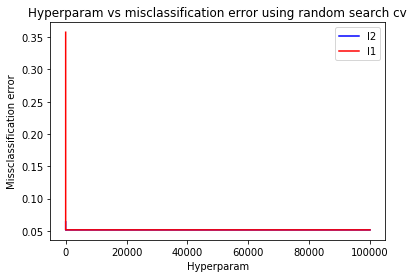

In [149]:
acc_score_l2= tfidf_w2vec_l2_clf_using_random.cv_results_.get('mean_test_score')
error_l2 = [1-x for x in acc_score_l2]

acc_score_l1= tfidf_w2vec_l1_clf_using_random.cv_results_.get('mean_test_score')
error_l1 = [1-x for x in acc_score_l1]

hyperparam = np.array( [0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000] )

plt.plot(hyperparam ,error_l2 ,'b', label="l2" )
plt.plot(hyperparam ,error_l1 ,'r', label="l1" )
plt.xlabel('Hyperparam')
plt.ylabel('Missclassification error')
plt.title('Hyperparam vs misclassification error using random search cv')
plt.legend()
plt.show()

hyperparam lambda for l2 reg: {'C': 0.1}
Test accuracy:  0.9479468220456181
Train accuracy:  0.9486473479499175
              precision    recall  f1-score   support

          -1       0.71      0.40      0.51      3702
           1       0.92      0.98      0.95     26298

   micro avg       0.91      0.91      0.91     30000
   macro avg       0.82      0.69      0.73     30000
weighted avg       0.89      0.91      0.89     30000



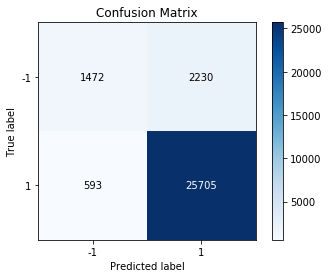

In [150]:
# best hyperparam for l2 reg
print("hyperparam lambda for l2 reg:" ,tfidf_w2vec_l2_clf_using_random.best_params_ )
# test accuracy
print('Test accuracy: ',tfidf_w2vec_l2_clf_using_random.score(tfidf_w2vec_std_X_test_matrix , Y_test))
# train accuracy
print('Train accuracy: ',tfidf_w2vec_l2_clf_using_random.score(tfidf_w2vec_std_X_train_matrix , Y_train))

test_prediction = tfidf_w2vec_l2_clf_using_random.predict(tfidf_w2vec_std_X_test_matrix)
print(classification_report(Y_test, test_prediction))
import scikitplot.metrics as sciplot
sciplot.plot_confusion_matrix(Y_test, test_prediction)
plt.show()

hyperparam lambda for l1 reg: {'C': 1}
Test accuracy:  0.9479353018203279
Train accuracy:  0.9486473479499175
              precision    recall  f1-score   support

          -1       0.71      0.40      0.51      3702
           1       0.92      0.98      0.95     26298

   micro avg       0.91      0.91      0.91     30000
   macro avg       0.82      0.69      0.73     30000
weighted avg       0.89      0.91      0.89     30000



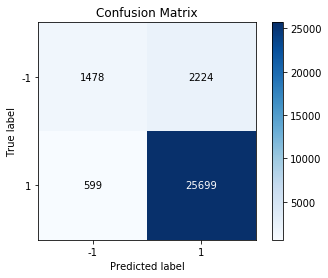

In [151]:
# best hyperparam for l1 reg
print("hyperparam lambda for l1 reg:" ,tfidf_w2vec_l1_clf_using_random.best_params_ )
# test accuracy
print('Test accuracy: ',tfidf_w2vec_l1_clf_using_random.score(tfidf_w2vec_std_X_test_matrix , Y_test))
# train accuracy
print('Train accuracy: ',tfidf_w2vec_l1_clf_using_random.score(tfidf_w2vec_std_X_train_matrix , Y_train))

test_prediction = tfidf_w2vec_l1_clf_using_random.predict(tfidf_w2vec_std_X_test_matrix)
print(classification_report(Y_test, test_prediction))
import scikitplot.metrics as sciplot
sciplot.plot_confusion_matrix(Y_test, test_prediction)
plt.show()


## sparsity vs lambda

In [152]:
C = [100,10,0.1,0.01,0.001]
acc=[]
non_zero_weight = []

for val in C:
    model = LogisticRegression(C= val, penalty= 'l1')
    model.fit(w2vec_std_X_train_matrix,Y_train)
    prediction = model.predict(w2vec_std_X_test_matrix)
    non_zero_weight.append(np.count_nonzero(model.coef_))
    acc.append(accuracy_score(Y_test, prediction)*100)
    print('______________________________________________________________________________')
    print('C = ' , val)
    print(classification_report(Y_test, prediction))
    print('______________________________________________________________________________')

______________________________________________________________________________
C =  100
              precision    recall  f1-score   support

          -1       0.74      0.52      0.61      3702
           1       0.93      0.97      0.95     26298

   micro avg       0.92      0.92      0.92     30000
   macro avg       0.84      0.74      0.78     30000
weighted avg       0.91      0.92      0.91     30000

______________________________________________________________________________
______________________________________________________________________________
C =  10
              precision    recall  f1-score   support

          -1       0.74      0.52      0.61      3702
           1       0.93      0.97      0.95     26298

   micro avg       0.92      0.92      0.92     30000
   macro avg       0.84      0.74      0.78     30000
weighted avg       0.91      0.92      0.91     30000

______________________________________________________________________________
_____________

In [153]:
print('C              ' , C)
print('accuracy       ',acc)
print('non zero weight' ,non_zero_weight )

C               [100, 10, 0.1, 0.01, 0.001]
accuracy        [91.76666666666667, 91.76666666666667, 91.78, 91.67, 89.96333333333332]
non zero weight [50, 50, 49, 44, 20]


### Observation

In [1]:
from prettytable import PrettyTable
x = PrettyTable()

In [2]:
x.field_names = ["Vectorizer", "Cross Validation", "Regulizer","C", "Train accuracy" , "Test accuracy","f1-score"]
x.add_row(['BOW' , 'GridSearch' , 'L1' ,'0.01', '99.9','96.5','0.93' ])
x.add_row(['BOW' , 'GridSearch' , 'L2' ,'100','99.9','95.1','0.89' ])
x.add_row(['BOW' , 'RandomSearch' , 'L1' ,'0.01', '99.9','96.5','0.93' ])
x.add_row(['BOW' , 'RandomSearch' , 'L2' , '100','99.9','95.1','0.89'])

x.add_row(['TF-IDF' , 'GridSearch' , 'L1' ,'0.01', '99.9','96.7','0.94' ])
x.add_row(['TF-IDF' , 'GridSearch' , 'L2' ,'100','99.9','94.7','0.88' ])
x.add_row(['TF-IDF' , 'RandomSearch' , 'L1' ,'0.01', '99.9','96.7','0.94' ])
x.add_row(['TF-IDF' , 'RandomSearch' , 'L2' , '100','99.9','94.7','0.88'])

x.add_row(['W2vec' , 'GridSearch' , 'L1' ,'1', '95.5','95.4','0.91' ])
x.add_row(['W2vec' , 'GridSearch' , 'L2' ,'100','95.5','95.4','0.9' ])
x.add_row(['W2vec' , 'RandomSearch' , 'L1' ,'10','95.5','95.3','0.91' ])
x.add_row(['W2vec' , 'RandomSearch' , 'L2' , '100','95.5','95.4','0.91'])

x.add_row(['Tf-Idf W2vec' , 'GridSearch' , 'L1' ,'1', '94.8','94.7','0.89' ])
x.add_row(['Tf-idf W2vec' , 'GridSearch' , 'L2' ,'10000','94.8','94.7','0.89' ])
x.add_row(['Tf-idf W2vec' , 'RandomSearch' , 'L1' ,'1','94.8','94.7','0.89' ])
x.add_row(['Tf-idf W2vec' , 'RandomSearch' , 'L2' , '0.1','94.8','94.7','0.89'])

print(x)

+--------------+------------------+-----------+-------+----------------+---------------+----------+
|  Vectorizer  | Cross Validation | Regulizer |   C   | Train accuracy | Test accuracy | f1-score |
+--------------+------------------+-----------+-------+----------------+---------------+----------+
|     BOW      |    GridSearch    |     L1    |  0.01 |      99.9      |      96.5     |   0.93   |
|     BOW      |    GridSearch    |     L2    |  100  |      99.9      |      95.1     |   0.89   |
|     BOW      |   RandomSearch   |     L1    |  0.01 |      99.9      |      96.5     |   0.93   |
|     BOW      |   RandomSearch   |     L2    |  100  |      99.9      |      95.1     |   0.89   |
|    TF-IDF    |    GridSearch    |     L1    |  0.01 |      99.9      |      96.7     |   0.94   |
|    TF-IDF    |    GridSearch    |     L2    |  100  |      99.9      |      94.7     |   0.88   |
|    TF-IDF    |   RandomSearch   |     L1    |  0.01 |      99.9      |      96.7     |   0.94   |


#### Conclusion
1. Performance of Logistic Regression on unseen  text data is quite good.
2. Classification of text using logistic Regression with Vectorization techniques like BOW and Tf-Idf is better than average word2vec and tf-idf word2vec.
3. the algorithm is fast, both the training and testing time was considerably lesser than other algorithms like kNN.
4. Logistic Regression can perform well even in high dimensional data hence it is good for text classification.
5. Performance of model was almost similar with GridSearch and RandomSearch cross validation
6. Both regulizer l1 and l2 were giving almost similar results but l1 was little better. 
7. sparsity of weight vectore increases with incresing value of lambda.
